## Introduction

### What is sentiment analysis?
Sentiment analysis is the computational task of automatically determining what feelings a writer is expressing in text. Sentiment is often framed as a binary distinction (positive vs. negative), but it can also be a more fine-grained, like identifying the specific emotion an author is expressing (like fear, joy or anger).

Sentiment analysis is used for many applications, especially in business intelligence. Some examples of applications for sentiment analysis include:

 - Analyzing the social media discussion around a certain topic
 - Evaluating survey responses
 - Determining whether product reviews are positive or negative

Sentiment analysis is not perfect, and as with any automatic analysis of language, you will have errors in your results. However, it can be useful to quickly summarize some qualities of text, especially if you have so much text that a human reader cannot analyze all of it.

For this project,the goal is to to classify Food reviews based on customers' text.

### The Dataset
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 — Oct 2012

Number of Attributes/Columns in data: 10

#### The column or features in the dataset:
 - Id
 - ProductId — unique identifier for the product
 - UserId — unqiue identifier for the user
 - ProfileName
 - HelpfulnessNumerator — number of users who found the review helpful
 - HelpfulnessDenominator — number of users who indicated whether they found the review helpful or not
 - Score — rating between 1 and 5
 - Time — timestamp for the review
 - Summary — brief summary of the review
 - Text — text of the review

### Import Libraries

In [143]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
print(os.listdir("../input"))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.colors as mcolors
from tqdm import tqdm
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
#load the model
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


['amazon-fine-food-reviews']


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Load Dataset

In [144]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

# get 2000 tweets
df = df.sample(n=50000, random_state=0)

print(f"Shape of Dataset: {df.shape}")
df.head()

Shape of Dataset: (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
11214,11215,B001KVPC0G,A1FJEIB7HQ22ME,Marty Whitman,5,5,5,1334188800,Yes!!!,I could live off of these! I'm not kidding. Th...
222079,222080,B000OJ1H36,A1P59RM84ZIA0C,trail mix junkie,0,0,5,1325808000,Tropical Trail Mix,I found this product in a local grocery store ...
251082,251083,B0009F8JRC,ASPAJS6WD8CWY,Lanette Hawkes,1,2,5,1223510400,Great Gummies!,My young son is taking Chinese in school and w...
317731,317732,B005K4Q1RW,A2020KL55SYZ4U,Paula E. Williams,0,0,5,1334534400,I'm addicted to this!,I love Grove Square Spiced Apple Cider Cups (s...
404652,404653,B00153C4B4,A22BGI38W7Q9X9,PracticalWaysToSaveMoney,0,0,2,1332547200,"Tastes Eh, Very Expensive",This is probably my shortest review but there'...


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 11214 to 460890
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      50000 non-null  int64 
 1   ProductId               50000 non-null  object
 2   UserId                  50000 non-null  object
 3   ProfileName             49996 non-null  object
 4   HelpfulnessNumerator    50000 non-null  int64 
 5   HelpfulnessDenominator  50000 non-null  int64 
 6   Score                   50000 non-null  int64 
 7   Time                    50000 non-null  int64 
 8   Summary                 49997 non-null  object
 9   Text                    50000 non-null  object
dtypes: int64(5), object(5)
memory usage: 4.2+ MB


In [146]:
# Removing the Duplicates if any from the dataset
df.duplicated().sum()
df.drop_duplicates(inplace=True)

# Remove any NaN values from the dataset
df.isnull().sum()
df.dropna(how='any',inplace=True)

# Since we are evaluating Sentiment, any Score > 3 is positive
df["Sentiment"] = df["Score"].apply(lambda score: 1 if score > 3 else 0)

In [147]:
print(df['Sentiment'])

11214     1
222079    1
251082    1
317731    1
404652    0
         ..
161543    1
357201    0
215262    1
32669     1
460890    1
Name: Sentiment, Length: 49993, dtype: int64


In [148]:
# Extract Score and Text columns to get just the relevant info
sentiment_df = pd.DataFrame(df, columns=['Sentiment', 'Text'])

sentiment_df['Sentiment'].astype('category').value_counts()

Sentiment
1    39053
0    10940
Name: count, dtype: int64

### Plot the Scores using seaborn

Text(0.5, 1.0, 'Sentiment')

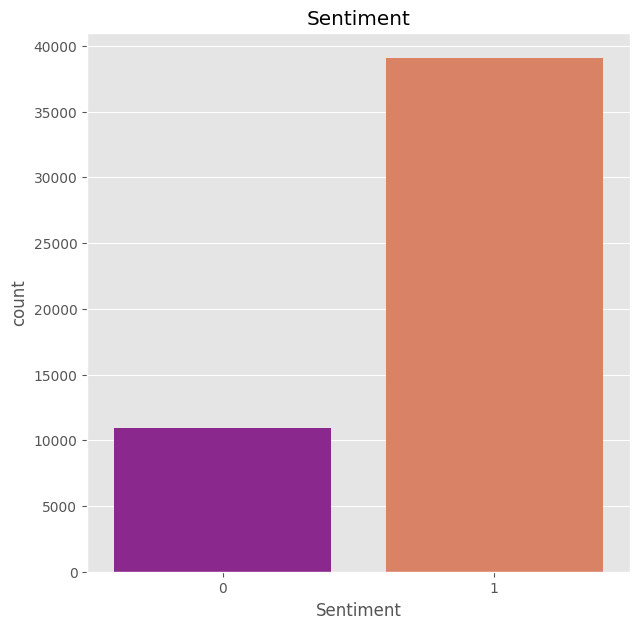

In [149]:
import seaborn as sns
sns.countplot(x='Sentiment', data=sentiment_df, palette="plasma")
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.title('Sentiment')

### Text Pre-processing

In [150]:
# Helper Functions
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def preprocess(text):
    output = text.lower()
    output = remove_urls(output)
    output = re.sub("@[A-Za-z0-9_]+","", output)
    output = re.sub("#[A-Za-z0-9_]+","", output)
    return output
    
sentiment_df['Text'] = sentiment_df['Text'].apply(lambda text: preprocess(text))

### Train/Test Split (90/10)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    sentiment_df['Text'], 
    sentiment_df['Sentiment'], 
    test_size=0.1, random_state=0
)
y_train.head()

566570    0
107296    1
453830    1
382841    1
26118     0
Name: Sentiment, dtype: int64

### Transforming Data into input for the BERT model

In [152]:
# Helper Functions

# can be up to 512 for BERT
max_length = 512
batch_size = 6

# The encode_plus  function of the tokenizer class will tokenize the raw input, 
# add the special tokens, and pad the vector to a size equal to max length (512).
def convert_example_to_feature(review):
      return bert_tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
    
# The following helper functions will help us to transform our raw data to an appropriate format ready to 
# feed into the BERT model
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
      return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label
    
def encode_examples(X,y):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    for text, label in zip(X, y):
        bert_input = convert_example_to_feature(text)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [153]:
# Create encoded datasets
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
ds_train_encoded = encode_examples(X_train, y_train).batch(batch_size)
ds_val_encoded = encode_examples(X_validation, y_validation).batch(batch_size)
# test dataset
ds_test_encoded = encode_examples(X_test, y_test).batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Compile BERT model

In [154]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 2 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 2
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


### Training the BERT model

In [155]:
bert_model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_val_encoded)
loss, acc = bert_model.evaluate(ds_test_encoded, verbose=0)
print("accuracy: {:5.2f}%".format(100 * acc))

Epoch 1/2
6749/6749 [==============================] - 3175s 461ms/step - loss: 0.2098 - accuracy: 0.9157 - val_loss: 0.1930 - val_accuracy: 0.9229
Epoch 2/2
6749/6749 [==============================] - 3099s 459ms/step - loss: 0.1140 - accuracy: 0.9582 - val_loss: 0.2678 - val_accuracy: 0.9171
accuracy: 91.60%


### Test on random text

In [ ]:
test_sentence = "This is a really bad steak. I hated it and will never buy again"

predict_input = bert_tokenizer.encode(test_sentence,

truncation=True,

padding=True,

return_tensors="tf")

tf_output = bert_model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

### Saving the model

In [156]:
bert_model.save_pretrained("outputs/bert_model_1", saved_model=True)